In [22]:
import warnings
warnings.filterwarnings('ignore')

In [23]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow as keras
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from keras.regularizers import l2
from keras import layers
from keras.models import Sequential, Model
from keras.layers import Embedding, SimpleRNN, Dense, Dropout, LSTM, Bidirectional, Input
from keras.layers import Attention, GlobalAveragePooling1D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import stanza
from keras.utils import to_categorical
from keras.layers import BatchNormalization, Dropout

*<h3>Load Data<h3>*

In [24]:
# read csv file into pandas
df = pd.read_csv("../datasets/shuffled3.csv")
df.head(10)

,question_id,answer,grade
0,3,من خزائن العطاء الإلهي، انبلج سيلان: الأول حب ...,2
1,3,السيدة فاطمة هي الأم الزكية للنبي,0
2,3,في ظلال الكعبة المشرفة، رأت آمنة بنت وهب فجر ا...,2
3,3,الرسول محمد والدته ابنة وهب.,1
4,3,عائشة هي الأم الصالحة لنبي الإسلام,0
5,3,عائشة أم الرسول,0
6,3,على دروب مكة المكرمة، خطت آمنة بنت وهب خطواتها...,2
7,3,من بطنها انبثق النور، ومن حنانها نهل كل روح، ب...,1
8,3,خديجةُ نموذجٌ للمرأةِ المسلمةِ المثاليةِ، التي...,0
9,3,بصوتٍ حنونٍ كصوت المطر، أرضعت آمنة بنت وهب محم...,2


*<h3>EDA<h3>*

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78 entries, 0 to 77
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   question_id  78 non-null     int64 
 1   answer       78 non-null     object
 2   grade        78 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 2.0+ KB


In [26]:
df.groupby('grade').size()

grade
0    25
1    18
2    35
dtype: int64

In [27]:
df.duplicated().sum()

0

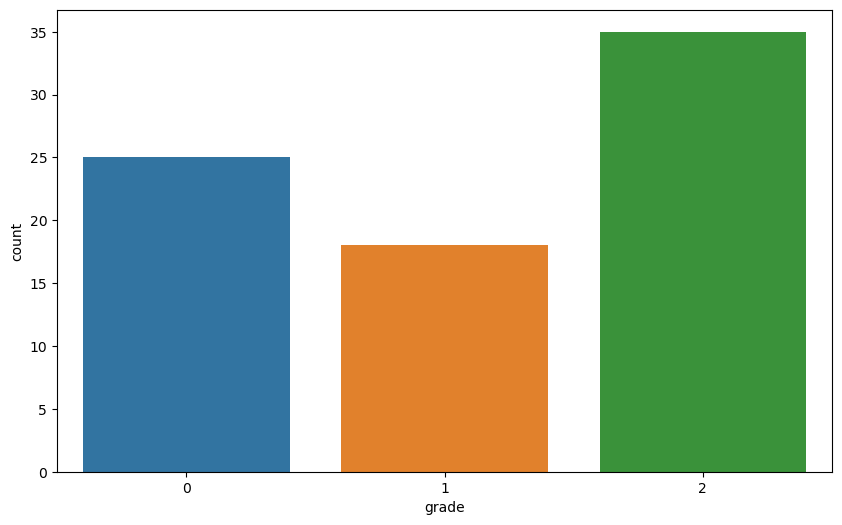

In [28]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='grade')
plt.show()

*<h3>Data Cleaning<h3>*

In [29]:
df.drop('question_id', axis=1, inplace=True)

In [30]:
df.dropna(inplace=True)

In [31]:
df.drop_duplicates(inplace=True)
print(df['answer'])

0     من خزائن العطاء الإلهي، انبلج سيلان: الأول حب ...
1                     السيدة فاطمة هي الأم الزكية للنبي
2     في ظلال الكعبة المشرفة، رأت آمنة بنت وهب فجر ا...
3                          الرسول محمد والدته ابنة وهب.
4                    عائشة هي الأم الصالحة لنبي الإسلام
                            ...                        
73                                      آمنة، أم النبي.
74    تحتضن السيرة العطرة اسم آمنة بنت وهب، أم رسول ...
75                       الأم الكريمة عائشة هي أم النبي
76    جذور النبوة امتزجت في بنت وهب، لتمنحنا خير الأ...
77                                    ولّدت آمنة النبي.
Name: answer, Length: 78, dtype: object


*<h3>Data Pre-Preocessing<h3>*

In [32]:
le = LabelEncoder()
df['grade'] = le.fit_transform(df['grade'])

stanza.download('ar')
nlp = stanza.Pipeline('ar')

def preprocess_text(text):
    doc = nlp(text)
    tokens = [word.lemma for sent in doc.sentences for word in sent.words if word.upos != 'PUNCT']
    return tokens

df['answer'] = df['answer'].apply(preprocess_text)

2024-01-09 22:44:05 INFO: Downloading default packages for language: ar (Arabic) ...
2024-01-09 22:44:07 INFO: File exists: C:\Users\amine\stanza_resources\ar\default.zip
2024-01-09 22:44:10 INFO: Finished downloading models and saved to C:\Users\amine\stanza_resources.
2024-01-09 22:44:10 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2024-01-09 22:44:13 INFO: Loading these models for language: ar (Arabic):
| Processor | Package       |
-----------------------------
| tokenize  | padt          |
| mwt       | padt          |
| pos       | padt_charlm   |
| lemma     | padt_nocharlm |
| depparse  | padt_charlm   |
| ner       | aqmar_charlm  |

2024-01-09 22:44:13 INFO: Using device: cpu
2024-01-09 22:44:13 INFO: Loading: tokenize
2024-01-09 22:44:13 INFO: Loading: mwt
2024-01-09 22:44:13 INFO: Loading: pos
2024-01-09 22:44:13 INFO: Loading: lemma
2024-01-09 22:44:13 INFO: Loading: depparse
2024-01-09 22:44:14 INFO: Loading: ner
2024-01-09 22:44:14 INFO: Done loading processors!


In [33]:
# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['answer'])
sequences = tokenizer.texts_to_sequences(df['answer'])
max_sequence_length = max(len(s) for s in sequences)
sequences = pad_sequences(sequences,max_sequence_length)
word2idx = tokenizer.word_index
vocab_size = len(word2idx) + 1


X = pad_sequences(sequences, padding='post', truncating='post', maxlen=max_sequence_length)

print(sequences)
print(df['answer'])

Y = to_categorical(df['grade'], num_classes=3)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=42)


[[  0   0   0 ...   4   1  13]
 [  0   0   0 ...   8 110  11]
 [  0   0   0 ...  35 115   2]
 ...
 [  0   0   0 ...   2   8  11]
 [  0   0   0 ... 310  87  17]
 [  0   0   0 ... 311   3  11]]
0     [مِن, خَزِينَة, عَطَاء, إِلٰهِيّ, اِنبَلَج, سَ...
1         [سَيِّدَة, فاطمة, هُوَ, أُمّ, زَكِيّ, نَبِيّ]
2     [فِي, ظِلَال, كُعبَة, مُشَرَّف, رَأَى, آمِن, ب...
3      [رَسُول, محمد, وَالِدَة, هُوَ, اِبنَة, وَ, هَبّ]
4      [عائشة, هُوَ, أُمّ, صَالِح, لِ, نَبِيّ, إِسلَام]
                            ...                        
73                                  [آمِن, أَم, نَبِيّ]
74    [اِحتَضَن, سِيرَة, عُطر, اِسم, آمِن, بنت, وَ, ...
75            [أُمّ, كَرِيم, عائشة, هُوَ, أُمّ, نَبِيّ]
76    [جِذر, نُبُوَّة, اِمتَزَج, فِي, بنت, وَ, هُبّ,...
77                           [وَ, لَدَّى, آمِن, نَبِيّ]
Name: answer, Length: 78, dtype: object


*<h3>build Models<h3>*

*<h4>RNN Model<h4>*

In [34]:
from tensorflow.keras.callbacks import ReduceLROnPlateau


X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = train_test_split(X, Y, test_size=0.2)

def RNN_model(vocab_size, sequence_length):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=sequence_length))
    model.add(SimpleRNN(units=128, activation='relu', return_sequences=True))
    model.add(BatchNormalization())
    model.add(SimpleRNN(units=64, activation='sigmoid'))
    model.add(Dense(256, activation='sigmoid', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.2))
    model.add(Dense(3, activation='softmax'))

    optimizer = Adam(learning_rate=0.001)
    
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001, verbose=1)
#EMBEDDING_DIM = 110
rnn_model = RNN_model(vocab_size, max_sequence_length)
early_stopping_rnn = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history_updated_rnn = rnn_model.fit(X_train_rnn, y_train_rnn, validation_data=(X_test_rnn, y_test_rnn), epochs=100, batch_size=64, callbacks=[reduce_lr])

# Evaluate the RNN model
evaluation_metrics_updated_rnn = rnn_model.evaluate(X_test, Y_test)
print("Evaluation Metrics for RNN:")
for metric_name, metric_value in zip(rnn_model.metrics_names, evaluation_metrics_updated_rnn):
    print(f"{metric_name}: {metric_value}")

Epoch 1/100
1/1 [==============================] - 5s 5s/step - loss: 1.4001 - accuracy: 0.2742 - val_loss: 1.2497 - val_accuracy: 0.3125 - lr: 0.0010
Epoch 2/100
1/1 [==============================] - 0s 57ms/step - loss: 1.2663 - accuracy: 0.2903 - val_loss: 1.2060 - val_accuracy: 0.3125 - lr: 0.0010
Epoch 3/100
1/1 [==============================] - 0s 55ms/step - loss: 1.1740 - accuracy: 0.4032 - val_loss: 1.1975 - val_accuracy: 0.3750 - lr: 0.0010
Epoch 4/100
1/1 [==============================] - 0s 52ms/step - loss: 1.0476 - accuracy: 0.6290 - val_loss: 1.2187 - val_accuracy: 0.3750 - lr: 0.0010
Epoch 5/100
1/1 [==============================] - ETA: 0s - loss: 1.2052 - accuracy: 0.4032
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1/1 [==============================] - 0s 56ms/step - loss: 1.2052 - accuracy: 0.4032 - val_loss: 1.2540 - val_accuracy: 0.3750 - lr: 0.0010
Epoch 6/100
1/1 [==============================] - 0s 54ms/step - loss: 1.0930 

*<h4>LSTM Model<h4>*

In [35]:
def LSTM_model(vocab_size, sequence_length):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=sequence_length))
    model.add(LSTM(units=128, activation='relu', return_sequences=True))
    model.add(BatchNormalization())
    model.add(LSTM(units=64, activation='relu'))
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.2))
    model.add(Dense(3, activation='softmax'))

    optimizer = Adam(learning_rate=0.001)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


#EMBEDDING_DIM = 110
lstm_model = LSTM_model(vocab_size, max_sequence_length)
early_stopping_rnn = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history_updated_rnn = lstm_model.fit(X_train_rnn, y_train_rnn, validation_data=(X_test_rnn, y_test_rnn), epochs=100, batch_size=64, callbacks=[early_stopping_rnn])


# Evaluate the lstm model
evaluation_metrics_updated_lstm = lstm_model.evaluate(X_test, Y_test)
print("Evaluation Metrics for LSTM:")
for metric_name, metric_value in zip(lstm_model.metrics_names, evaluation_metrics_updated_lstm):
    print(f"{metric_name}: {metric_value}")

    

Epoch 1/100
1/1 [==============================] - 7s 7s/step - loss: 1.2150 - accuracy: 0.3226 - val_loss: 1.1985 - val_accuracy: 0.3750
Epoch 2/100
1/1 [==============================] - 0s 227ms/step - loss: 1.1559 - accuracy: 0.6290 - val_loss: 1.1964 - val_accuracy: 0.3750
Epoch 3/100
1/1 [==============================] - 0s 91ms/step - loss: 1.1063 - accuracy: 0.5484 - val_loss: 1.1944 - val_accuracy: 0.3750
Epoch 4/100
1/1 [==============================] - 0s 85ms/step - loss: 1.0632 - accuracy: 0.5806 - val_loss: 1.1926 - val_accuracy: 0.3750
Epoch 5/100
1/1 [==============================] - 0s 108ms/step - loss: 1.0078 - accuracy: 0.6129 - val_loss: 1.1907 - val_accuracy: 0.3750
Epoch 6/100
1/1 [==============================] - 0s 90ms/step - loss: 0.9457 - accuracy: 0.5968 - val_loss: 1.1892 - val_accuracy: 0.3750
Epoch 7/100
1/1 [==============================] - 0s 83ms/step - loss: 0.8645 - accuracy: 0.7258 - val_loss: 1.1883 - val_accuracy: 0.6250
Epoch 8/100
1/1 [===

*<h4>TRANSFORMER Model<h4>*

In [36]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, density, rate=0.1, l2_reg=0.01):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            layers.Dense(density, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
            layers.Dense(embed_dim, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

def build_transformer_model(maxlen, vocab_size, embed_dim, num_heads, density, transformer_units, mlp_units, dropout_rate, num_classes):
    inputs = layers.Input(shape=(maxlen,))
    embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
    x = embedding_layer(inputs)
    for _ in range(transformer_units):
        x = TransformerBlock(embed_dim, num_heads, density, rate=dropout_rate)(x)
    x = layers.GlobalAveragePooling1D()(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [37]:
maxlen = max_sequence_length
vocab_size = len(tokenizer.word_index) + 1
embed_dim = 120
num_heads = 2
density = 3
transformer_units = 4
mlp_units = [128]
dropout_rate = 0.5
num_classes = len(df['grade'].unique())

transformer_model = build_transformer_model(maxlen, vocab_size, embed_dim, num_heads, density, transformer_units, mlp_units, dropout_rate, num_classes)


In [38]:
transformer_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
transformer_model.fit(X_train, Y_train, epochs=30, batch_size=32, validation_data=(X_test, Y_test))
history = transformer_model.fit(X_train, Y_train, epochs=30, batch_size=32, validation_data=(X_test, Y_test))

Epoch 1/30
3/3 [==============================] - 16s 757ms/step - loss: 1.8096 - accuracy: 0.2879 - val_loss: 1.6058 - val_accuracy: 0.4167
Epoch 2/30
3/3 [==============================] - 0s 75ms/step - loss: 1.6686 - accuracy: 0.4242 - val_loss: 1.5668 - val_accuracy: 0.4167
Epoch 3/30
3/3 [==============================] - 1s 214ms/step - loss: 1.5590 - accuracy: 0.4394 - val_loss: 1.7208 - val_accuracy: 0.4167
Epoch 4/30
3/3 [==============================] - 0s 79ms/step - loss: 1.4725 - accuracy: 0.5000 - val_loss: 1.5734 - val_accuracy: 0.4167
Epoch 5/30
3/3 [==============================] - 1s 241ms/step - loss: 1.4542 - accuracy: 0.5000 - val_loss: 1.5181 - val_accuracy: 0.4167
Epoch 6/30
3/3 [==============================] - 0s 70ms/step - loss: 1.4267 - accuracy: 0.5758 - val_loss: 1.6197 - val_accuracy: 0.2500
Epoch 7/30
3/3 [==============================] - 0s 96ms/step - loss: 1.4814 - accuracy: 0.4545 - val_loss: 1.4468 - val_accuracy: 0.6667
Epoch 8/30
3/3 [=======

In [39]:
evaluation_metrics_transformer = transformer_model.evaluate(X_test, Y_test)
print("Evaluation Metrics Transformer:")
for metric_name, metric_value in zip(transformer_model.metrics_names, evaluation_metrics_transformer):
    print(f"{metric_name}: {metric_value}")


1/1 [==============================] - 0s 304ms/step - loss: 0.8364 - accuracy: 0.9167
Evaluation Metrics Transformer:
loss: 0.8364205956459045
accuracy: 0.9166666865348816


In [40]:
evaluation_metrics_transformer = transformer_model.evaluate(X_test, Y_test)

predictions = transformer_model.predict(X_test)
print(X_test)

# Convert one-hot encoded labels to class indices
y_true = np.argmax(Y_test, axis=1)

# Convert predicted probabilities to class indices
y_pred = np.argmax(predictions, axis=1)

# Create DataFrame
results_df = pd.DataFrame({"Real": y_true, "Predicted": y_pred})

# Display DataFrame
print("\nReal and Predicted Values:")
print(results_df)


1/1 [==============================] - 2s 2s/step
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   28   1   2  47  87  17]
 [  0   0   0   0   0   0   0   0   6 103 104  60 105 106 107 108  20   1
  109  26   3   4   1  13]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    8 202   7   9   2  21]
 [  0   0   0   0   0   0   0   0   0   0   1 143   9  20   6  77   3   4
    1  13  18  15   2  24]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  49   1
   12   2  18  39 140  11]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   1 311   3  11]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  25  42
    2   8  17   7  11  14]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  21
    2   8 116   7  11  14]
 [  0   0   0   0   0   0   0   0   0  19 240 241   2  95  24  10 242   2
    4  86   5  46  14  32]
 [  0   0   0   0   0   0   0  10 101  55

In [41]:
# Evaluate RNN model
rnn_accuracy = rnn_model.evaluate(X_test, Y_test, verbose=0)[1]
print("Accuracy RNN:", rnn_accuracy)

# Evaluate LSTM model
lstm_accuracy = lstm_model.evaluate(X_test, Y_test, verbose=0)[1]
print("Accuracy LSTM:", lstm_accuracy)

# Evaluate Transformer model
transformer_accuracy = transformer_model.evaluate(X_test, Y_test, verbose=0)[1]
print("Accuracy Transformer:", transformer_accuracy)



Accuracy RNN: 0.4166666567325592
Accuracy LSTM: 0.5833333134651184
Accuracy Transformer: 0.9166666865348816


In [42]:
# Determine the best model
best_model_name, best_model_accuracy = max([('RNN', rnn_accuracy), ('LSTM', lstm_accuracy), ('Transformer', transformer_accuracy)], key=lambda x: x[1])

save_path = './savedModels/q3_model.h5'
# Save the best model
if best_model_name == 'RNN':
    rnn_model.save(save_path)
elif best_model_name == 'LSTM':
    lstm_model.save(save_path)
elif best_model_name == 'Transformer':
    transformer_model.save(save_path)

print(f"The best model ({best_model_name}) with accuracy {best_model_accuracy} has been saved to '{save_path}'")


The best model (Transformer) with accuracy 0.9166666865348816 has been saved to './savedModels/q3_model.h5'
